ARBOL DE DECISIONES


In [4]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
#smote
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

In [7]:
#  Cargar datasets
df_binary_train = pd.read_csv('df_binary_train.csv')
df_competencias = pd.read_csv('df_competencias.csv')


Eliminando columnas con 'TRAIN': ['DATASET']
 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.31      0.44      0.36         9
           1       0.97      0.95      0.96       178

    accuracy                           0.93       187
   macro avg       0.64      0.70      0.66       187
weighted avg       0.94      0.93      0.93       187



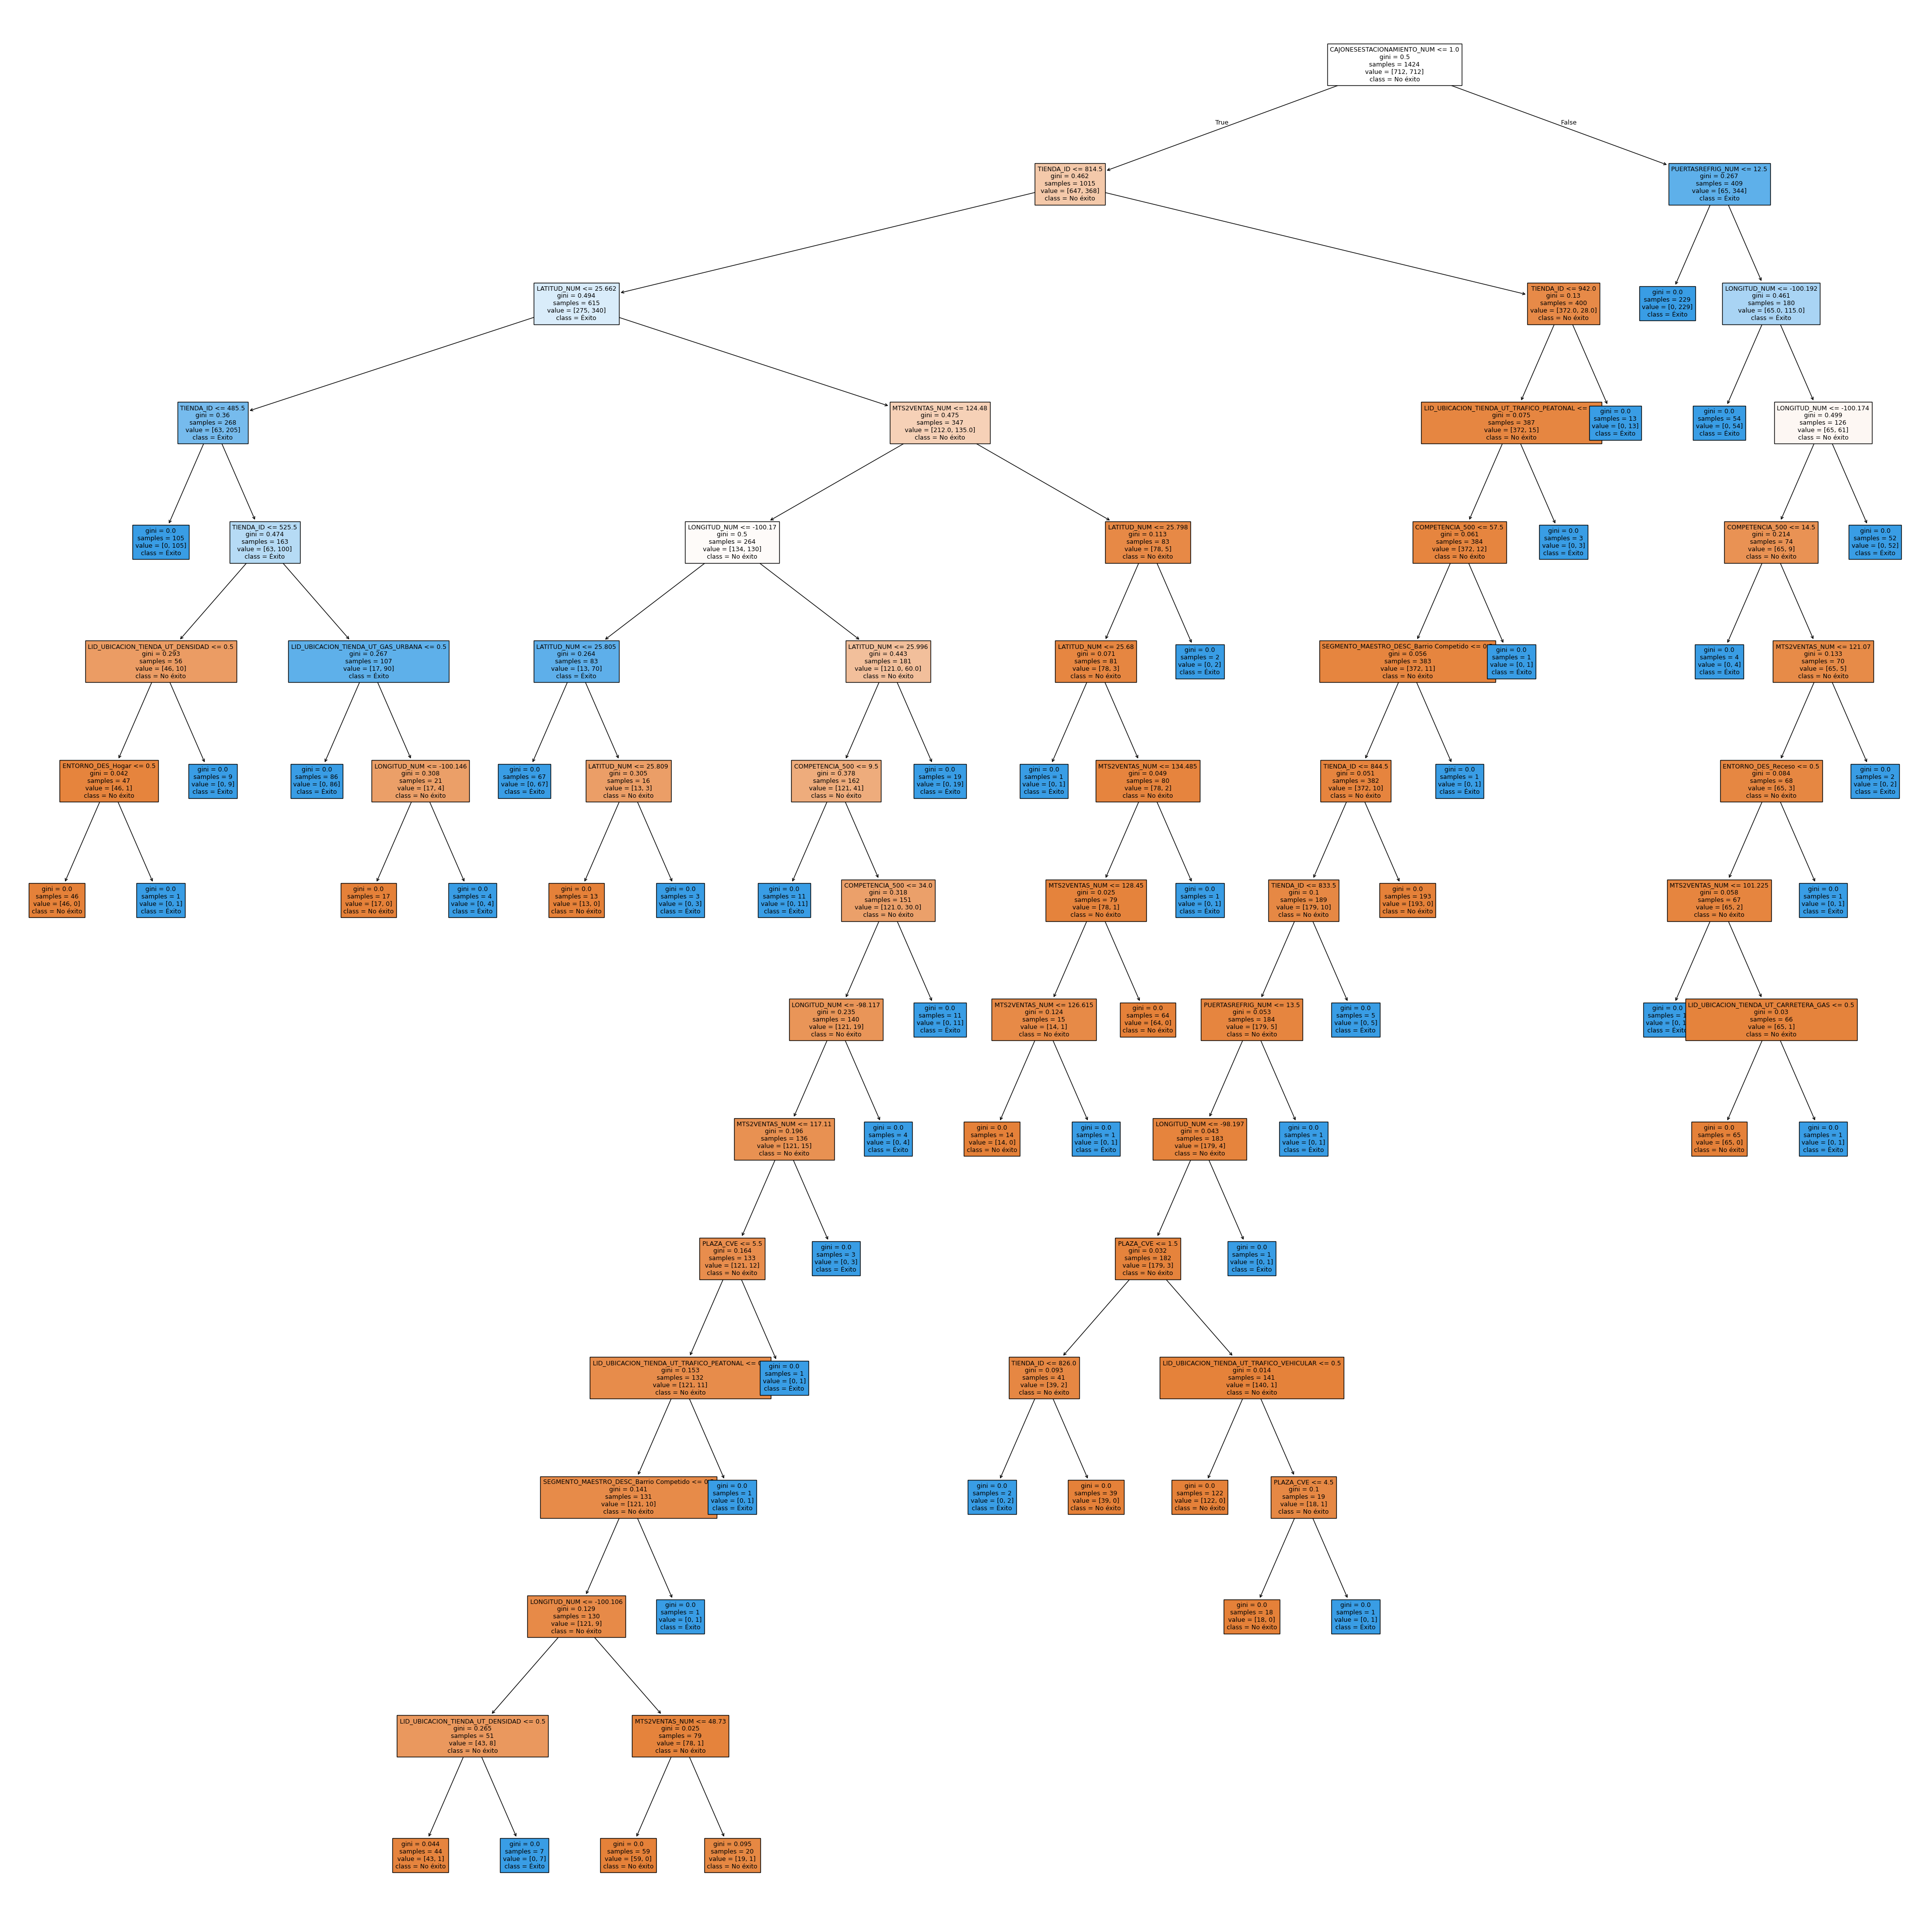

In [6]:

df = pd.merge(df_binary_train, df_competencias[['TIENDA_ID', 'COMPETENCIA_500']], on='TIENDA_ID', how='left')

# **Define X and y here**
# Assuming 'labelExito' is your target variable and 'TIENDA_ID' should be dropped
X = df.drop(columns=['labelExito'])
y = df['labelExito']


#  Eliminar columnas que contienen el valor 'TRAIN'
cols_with_train = [col for col in X.columns if X[col].astype(str).str.contains('TRAIN').any()]
print("Eliminando columnas con 'TRAIN':", cols_with_train)
X = X.drop(columns=cols_with_train)

#  Categóricas codificadas numéricamente
categorical_encoded = [
    'ENTORNO_DES', 'NIVELSOCIOECONOMICO_DES', 'LID_UBICACION_TIENDA', 'SEGMENTO_MAESTRO_DESC',
    # Agrega otras que sepas que representan categorías aunque estén como números
]

#  Variables numéricas reales (resto que no son categóricas)
numeric_cols = [col for col in X.columns if col not in categorical_encoded]

#  Separar datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#  Aplicar oversampling solo al conjunto de entrenamiento
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

#  Preprocesamiento: codificar categóricas y pasar las numéricas
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_encoded),
    ('num', 'passthrough', numeric_cols)
])

#  Árbol de decisión
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=15, random_state=0))  # quitamos class_weight aquí porque ya balanceamos
])

#  Entrenamiento con datos balanceados
clf.fit(X_resampled, y_resampled)

#  Evaluar en test
y_pred = clf.predict(X_test)
print(" Reporte de Clasificación:\n", classification_report(y_test, y_pred))

#  Obtener nombres de las características
# Need to fit the preprocessor first to get feature names correctly,
# or fit the entire pipeline which includes the preprocessor.
# Since the pipeline is already fitted, we can access the fitted preprocessor.
preprocessor_fitted = clf.named_steps['preprocessor']
cat_features = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_encoded)
feature_names = list(cat_features) + numeric_cols

#  Visualización del árbol
plt.figure(figsize=(50, 50))
plot_tree(clf.named_steps['classifier'],
          feature_names=feature_names,
          class_names=['No éxito', 'Éxito'],
          filled=True,
          fontsize=9)
plt.show()

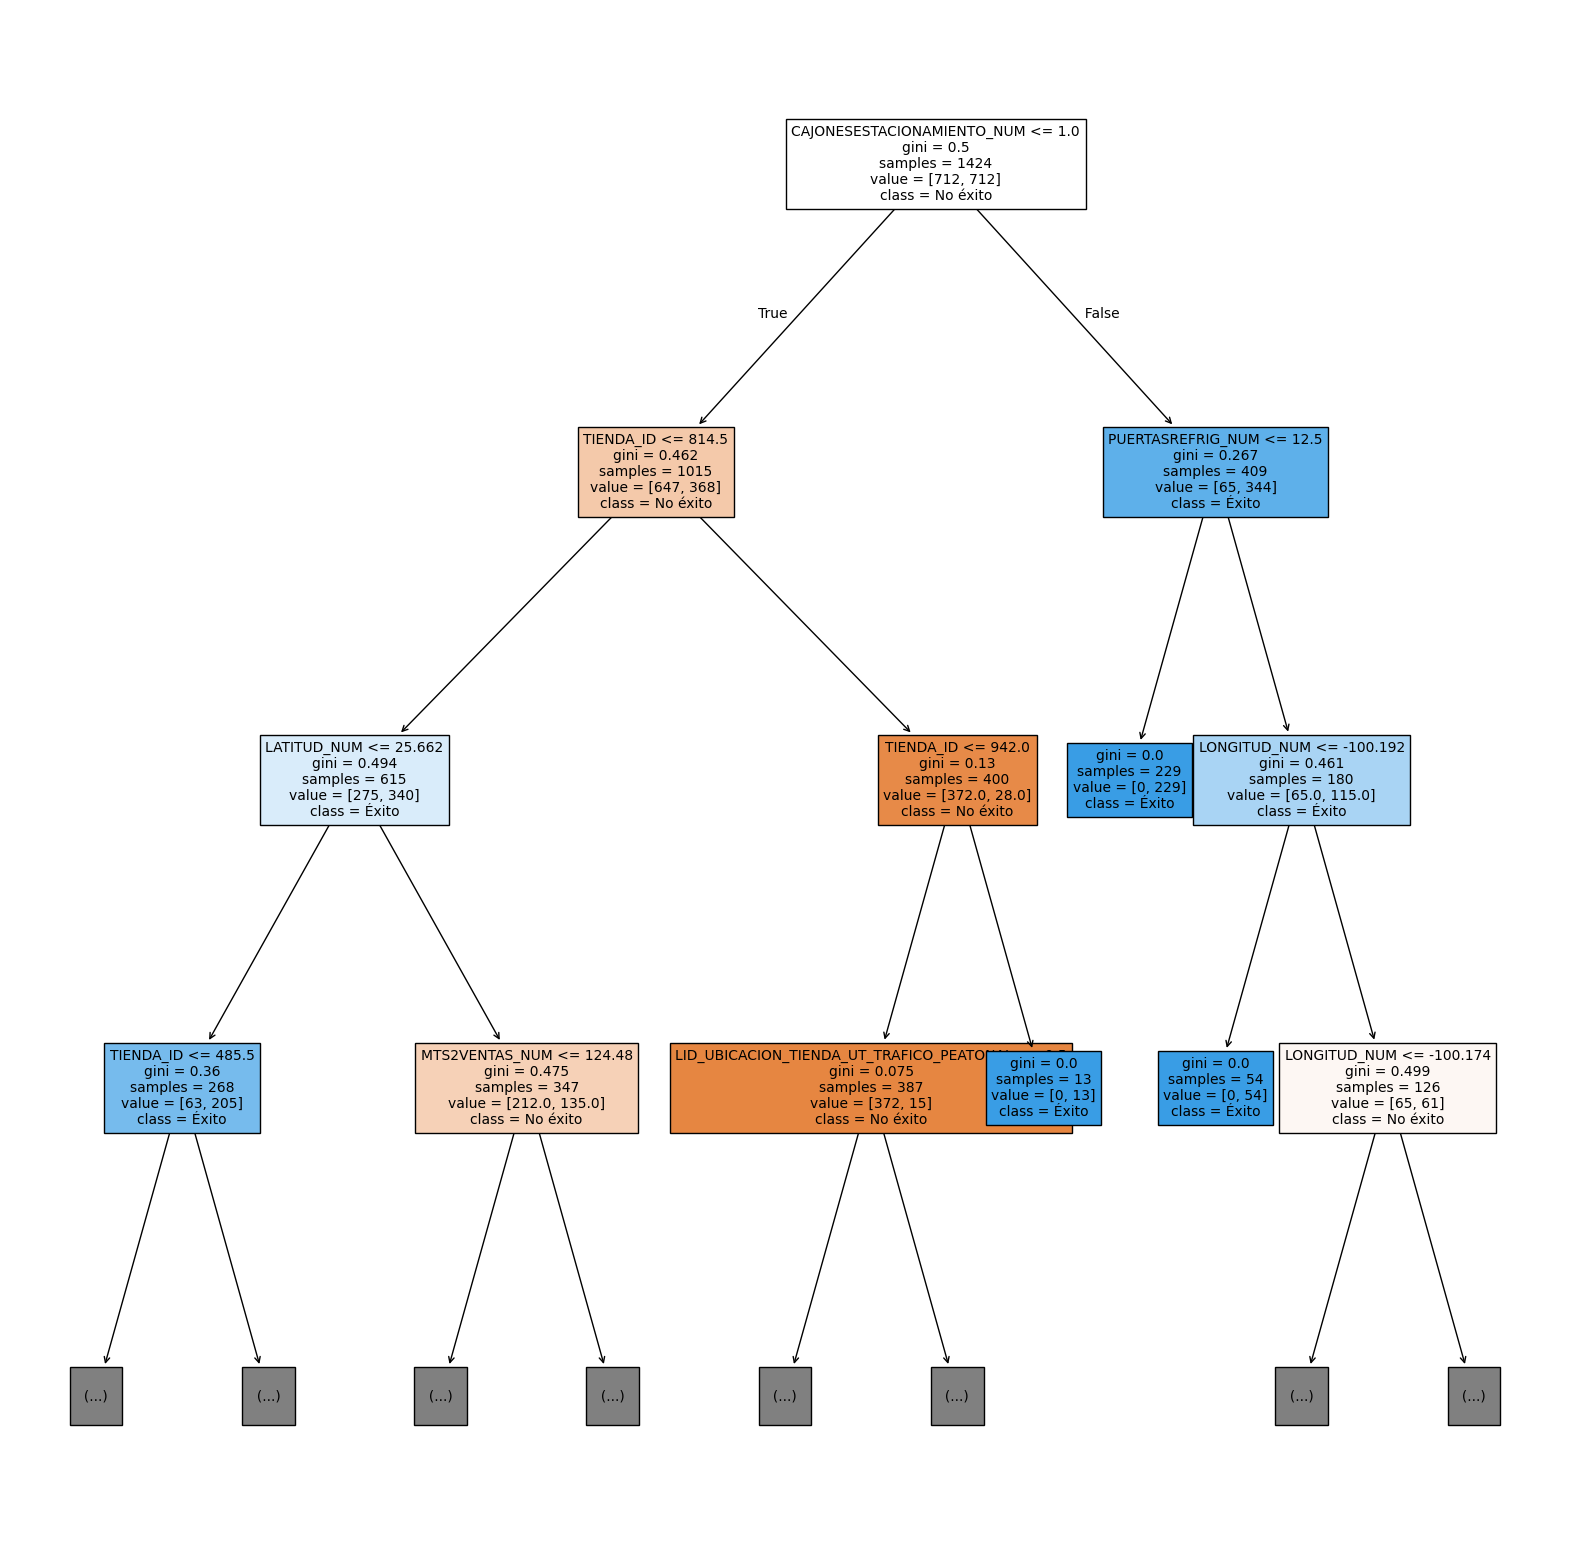

In [8]:
fig = plt.figure(figsize=(20, 20))
_ = plot_tree(clf.named_steps['classifier'],
              feature_names=feature_names,
              class_names=['No éxito', 'Éxito'],
              filled=True,
              fontsize=10,
              max_depth=3)  # Solo muestra los primeros 3 niveles del árbol
plt.show()

In [9]:

#  Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f" Falsos Positivos (FP): {fp}")
print(f" Falsos Negativos (FN): {fn}")
print(f" Verdaderos Positivos (TP): {tp}")
print(f" Verdaderos Negativos (TN): {tn}")

 Falsos Positivos (FP): 5
 Falsos Negativos (FN): 9
 Verdaderos Positivos (TP): 169
 Verdaderos Negativos (TN): 4


---------

GUARDAR EL MODELO


In [10]:
# (1) Librerías ──────────────────────────────────────────
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import joblib   # <-- para guardar
from google.colab import files  # opcional: descargar

# (2) Carga y limpieza rápida ────────────────────────────
df_bin   = pd.read_csv('df_binary_train.csv')
df_comp  = pd.read_csv('df_competencias.csv')

df = df_bin.merge(df_comp[['TIENDA_ID', 'COMPETENCIA_500']],
                  on='TIENDA_ID', how='left')

# columnas a descartar
cols_with_train = [c for c in df.columns
                   if df[c].astype(str).str.contains('TRAIN').any()]
X = df.drop(columns=cols_with_train + ['TIENDA_ID', 'labelExito'])
y = df['labelExito']

# (3) Definición de columnas ─────────────────────────────
categorical_cols = [
    'ENTORNO_DES', 'NIVELSOCIOECONOMICO_DES',
    'LID_UBICACION_TIENDA', 'SEGMENTO_MAESTRO_DESC'
]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# (4) Preprocesador + modelo ─────────────────────────────
pre = ColumnTransformer(
        [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
         ('num', 'passthrough', numeric_cols)]
      )

pipe = Pipeline([
        ('preprocessor', pre),
        ('classifier', DecisionTreeClassifier(
            max_depth=8,            # ⇦ ajusta si quieres
            class_weight='balanced',# ⇦ por el desbalance
            random_state=0))
      ])

# (5) Split, entrenamiento y evaluación rápida ───────────
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=0)
pipe.fit(X_tr, y_tr)

print("Accuracy de validación:", pipe.score(X_te, y_te))

# (6) ✅ Guardar el pipeline completo ────────────────────
joblib.dump(pipe, 'decision_tree_pipeline.joblib')

# (opcional) descargar al local si estás en Colab
# files.download('decision_tree_pipeline.joblib')


Accuracy de validación: 0.8288770053475936


['decision_tree_pipeline.joblib']